## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem
from sklearn.linear_model import LogisticRegressionCV
import torch

seed = 1234
np.random.seed(seed) 

## Loading and Scaling Data

In [2]:
# 1. Setup the paths
base_path = "." 
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

# 2. Read CSV file
df = pd.read_csv(csv_file)

# Lists to store our data
data = []   # This will become X
labels = [] # This will become y

# Define a fixed size for images. For example, MINST is 28*28, here we do 64*64 
IMG_SIZE = 64

print("Loading images... this might take a moment.")

# 3. Loop through the CSV and load images
for index, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']

    img_path = os.path.join(images_folder, img_name)

    # Check if file actually exists to avoid errors
    if os.path.exists(img_path):
        # Load image in Grayscale (usually sufficient for emotion detection)
        # If you want color, remove the second argument.
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_array is not None:
            # Resize the image (Crucial step!)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            # Flatten the image
            # This converts the 2D image (64x64) into a 1D row of numbers (4096,)
            # This matches the format your professor used for X
            flat_array = new_array.flatten()
            
            data.append(flat_array)
            labels.append(emotion)

# 4. Convert to Numpy Arrays (X and y)
X = np.array(data)
y = np.array(labels)

print("Data loaded successfully!")
print(f"Features (X) shape: {X.shape}") # Should be (Number of images, 4096)
print(f"Labels (y) shape: {y.shape}")    # Should be (Number of images,)


Loading images... this might take a moment.
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)


## Training Data Splitting

In [3]:
# Split strategy: 70% train, 15% validation, 15% test
# Using stratified sampling to maintain class proportions (for imbalanced "disgust" class)

# First split: 70% train, 30% temp (which will become val + test)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X, y, 
    test_size=0.30,           # 30% goes to temp
    random_state=seed, 
    shuffle=True,
    stratify=y                # Maintain class proportions!
)

# Second split: Split the 30% temp into 50/50 -> 15% val, 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp, y_temp, 
    test_size=0.50,           # 50% of 30% = 15% of original
    random_state=seed, 
    shuffle=True,
    stratify=y_temp           # Maintain class proportions!
)

print(f"=== Data Split Summary ===")
print(f"Training set:   {X_tr.shape[0]:,} samples ({X_tr.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_te.shape[0]:,} samples ({X_te.shape[0]/len(X)*100:.1f}%)")
print(f"Total:          {len(X):,} samples")

# Verify stratification worked - check class distribution in each split
print(f"\n=== Class Distribution Verification ===")
for name, labels in [("Train", y_tr), ("Validation", y_val), ("Test", y_te)]:
    counts = pd.Series(labels).value_counts()
    min_class = counts.min()
    print(f"{name}: min class has {min_class} samples ('{counts.idxmin()}')")

# Scaling - fit ONLY on training data, transform all sets
scaler = StandardScaler()
scaler.fit(X_tr)                      # Fit only on training data
X_tr = scaler.transform(X_tr)         # Transform training
X_val = scaler.transform(X_val)       # Transform validation  
X_te = scaler.transform(X_te)         # Transform test

=== Data Split Summary ===
Training set:   9,583 samples (70.0%)
Validation set: 2,053 samples (15.0%)
Test set:       2,054 samples (15.0%)
Total:          13,690 samples

=== Class Distribution Verification ===
Train: min class has 6 samples ('contempt')
Validation: min class has 2 samples ('contempt')
Test: min class has 1 samples ('contempt')


## Logistic Regression Model

### Hyperparameter Search via Cross-Validation
We'll search over several hyperparameters:
- **C**: Regularization strength (inverse). Smaller = stronger regularization
- **penalty**: Type of regularization ('l1' for Lasso, 'l2' for Ridge)
- **solver**: Optimization algorithm (must be compatible with penalty choice)

We use 5-fold cross-validation on the training data, then evaluate the best models on the validation set.

In [4]:
from sklearn.model_selection import cross_val_score
import time

# Define hyperparameter grid
# C values: range from strong regularization (0.001) to weak regularization (100)
# Added more granularity around the 0.1 region which showed promise
C_values = [0.001, 0.005, 0.01, 0.05, 0.1]

# Penalty and solver combinations (must be compatible)
# AVOIDING 'saga' - it's extremely slow on high-dimensional data (4096 features)
# - 'l2' works with: 'lbfgs', 'newton-cg', 'sag'
# - 'l1' works with: 'liblinear' (but liblinear uses one-vs-rest, not multinomial)
penalty_solver_combos = [
    ('l2', 'lbfgs'),      # L2 with LBFGS - fast, default for multiclass
    ('l2', 'newton-cg'),  # L2 with Newton-CG - good for multiclass
    ('l1', 'liblinear'),  # L1 regularization (sparse) - liblinear is fast
]

# Store results
cv_results = []

print("=" * 70)
print("LOGISTIC REGRESSION HYPERPARAMETER SEARCH")
print("=" * 70)
print(f"Training set size: {X_tr.shape[0]} samples")
print(f"Feature dimension: {X_tr.shape[1]} features")
print(f"Using 5-fold cross-validation on training data")
print(f"Testing {len(C_values)} C values × {len(penalty_solver_combos)} penalty/solver combos")
print(f"Total configurations: {len(C_values) * len(penalty_solver_combos)}")
print("=" * 70)
print("NOTE: Skipping 'saga' solver - too slow for high-dimensional data")
print("=" * 70)

start_time_total = time.time()

for penalty, solver in penalty_solver_combos:
    print(f"\n--- Penalty: {penalty}, Solver: {solver} ---")
    
    for C in C_values:
        start_time = time.time()
        
        # Create model
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            class_weight='balanced',
            max_iter=2000,
            random_state=seed,
            n_jobs=-1 if solver != 'liblinear' else 1  # liblinear doesn't support n_jobs
        )
        
        # 5-fold cross-validation on training data
        cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)
        
        # Calculate metrics
        cv_mean_acc = cv_scores.mean()
        cv_std_acc = cv_scores.std()
        cv_mean_error = 1 - cv_mean_acc
        
        elapsed = time.time() - start_time
        
        # Store results
        cv_results.append({
            'C': C,
            'penalty': penalty,
            'solver': solver,
            'cv_mean_accuracy': cv_mean_acc,
            'cv_std_accuracy': cv_std_acc,
            'cv_mean_error': cv_mean_error,
            'time_seconds': elapsed
        })
        
        print(f"  C={C:<6} | CV Accuracy: {cv_mean_acc:.4f} ± {cv_std_acc:.4f} | "
              f"Error: {cv_mean_error:.4f} | Time: {elapsed:.1f}s")

total_time = time.time() - start_time_total
print(f"\n{'=' * 70}")
print(f"Total search time: {total_time/60:.1f} minutes")
print("=" * 70)

LOGISTIC REGRESSION HYPERPARAMETER SEARCH
Training set size: 9583 samples
Feature dimension: 4096 features
Using 5-fold cross-validation on training data
Testing 5 C values × 3 penalty/solver combos
Total configurations: 15
NOTE: Skipping 'saga' solver - too slow for high-dimensional data

--- Penalty: l2, Solver: lbfgs ---


  C=0.001  | CV Accuracy: 0.6264 ± 0.0082 | Error: 0.3736 | Time: 28.0s
  C=0.005  | CV Accuracy: 0.6605 ± 0.0031 | Error: 0.3395 | Time: 37.0s
  C=0.01   | CV Accuracy: 0.6715 ± 0.0062 | Error: 0.3285 | Time: 34.1s
  C=0.05   | CV Accuracy: 0.6843 ± 0.0036 | Error: 0.3157 | Time: 35.4s
  C=0.1    | CV Accuracy: 0.6837 ± 0.0051 | Error: 0.3163 | Time: 27.6s

--- Penalty: l2, Solver: newton-cg ---
  C=0.001  | CV Accuracy: 0.6264 ± 0.0085 | Error: 0.3736 | Time: 114.3s
  C=0.005  | CV Accuracy: 0.6606 ± 0.0031 | Error: 0.3394 | Time: 29.8s
  C=0.01   | CV Accuracy: 0.6717 ± 0.0058 | Error: 0.3283 | Time: 364.9s
  C=0.05   | CV Accuracy: 0.6835 ± 0.0027 | Error: 0.3165 | Time: 27.4s
  C=0.1    | CV Accuracy: 0.6842 ± 0.0037 | Error: 0.3158 | Time: 27.2s

--- Penalty: l1, Solver: liblinear ---


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.001  | CV Accuracy: 0.5016 ± 0.0004 | Error: 0.4984 | Time: 7.1s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.005  | CV Accuracy: 0.6278 ± 0.0111 | Error: 0.3722 | Time: 9.9s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.01   | CV Accuracy: 0.6922 ± 0.0057 | Error: 0.3078 | Time: 10.7s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.05   | CV Accuracy: 0.7192 ± 0.0044 | Error: 0.2808 | Time: 16.9s


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated

  C=0.1    | CV Accuracy: 0.7202 ± 0.0042 | Error: 0.2798 | Time: 27.8s

Total search time: 13.3 minutes


In [5]:
# Convert results to DataFrame and display
cv_results_df = pd.DataFrame(cv_results)

# Sort by CV accuracy (descending)
cv_results_df = cv_results_df.sort_values('cv_mean_accuracy', ascending=False).reset_index(drop=True)

print("=" * 70)
print("CROSS-VALIDATION RESULTS (sorted by CV accuracy)")
print("=" * 70)
print(cv_results_df.to_string(index=True))

# Get top 5 configurations
print("\n" + "=" * 70)
print("TOP 5 CONFIGURATIONS")
print("=" * 70)
for i, row in cv_results_df.head(5).iterrows():
    print(f"{i+1}. C={row['C']}, penalty={row['penalty']}, solver={row['solver']}")
    print(f"   CV Accuracy: {row['cv_mean_accuracy']:.4f} ± {row['cv_std_accuracy']:.4f}")
    print(f"   CV Error Rate: {row['cv_mean_error']:.4f}")
    print()

CROSS-VALIDATION RESULTS (sorted by CV accuracy)
        C penalty     solver  cv_mean_accuracy  cv_std_accuracy  cv_mean_error  time_seconds
0   0.100      l1  liblinear          0.720233         0.004203       0.279767     27.826211
1   0.050      l1  liblinear          0.719190         0.004401       0.280810     16.944679
2   0.010      l1  liblinear          0.692163         0.005710       0.307837     10.671390
3   0.050      l2      lbfgs          0.684338         0.003595       0.315662     35.436610
4   0.100      l2  newton-cg          0.684233         0.003684       0.315767     27.224367
5   0.100      l2      lbfgs          0.683712         0.005116       0.316288     27.632369
6   0.050      l2  newton-cg          0.683503         0.002657       0.316497     27.388807
7   0.010      l2  newton-cg          0.671711         0.005770       0.328289    364.939024
8   0.010      l2      lbfgs          0.671502         0.006224       0.328498     34.056225
9   0.005      l2  ne

In [6]:
# Evaluate top 5 models on VALIDATION set (not test!)
# This helps us pick the best model before final test evaluation

print("=" * 70)
print("VALIDATION SET EVALUATION (Top 5 CV models)")
print("=" * 70)

validation_results = []

for i, row in cv_results_df.head(5).iterrows():
    # Train model on full training set
    model = LogisticRegression(
        C=row['C'],
        penalty=row['penalty'],
        solver=row['solver'],
        class_weight='balanced',
        max_iter=2000,
        random_state=seed
    )
    model.fit(X_tr, y_tr)
    
    # Evaluate on training and validation sets
    train_acc = model.score(X_tr, y_tr)
    val_acc = model.score(X_val, y_val)
    
    validation_results.append({
        'C': row['C'],
        'penalty': row['penalty'],
        'solver': row['solver'],
        'cv_accuracy': row['cv_mean_accuracy'],
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'train_error': 1 - train_acc,
        'val_error': 1 - val_acc
    })
    
    print(f"\nConfig {i+1}: C={row['C']}, penalty={row['penalty']}, solver={row['solver']}")
    print(f"  CV Accuracy:    {row['cv_mean_accuracy']:.4f}")
    print(f"  Train Accuracy: {train_acc:.4f} (Error: {1-train_acc:.4f})")
    print(f"  Val Accuracy:   {val_acc:.4f} (Error: {1-val_acc:.4f})")

# Find best model based on validation accuracy
validation_df = pd.DataFrame(validation_results)
best_idx = validation_df['val_accuracy'].idxmax()
best_config = validation_df.loc[best_idx]

print("\n" + "=" * 70)
print("BEST MODEL (based on validation accuracy)")
print("=" * 70)
print(f"C = {best_config['C']}")
print(f"penalty = '{best_config['penalty']}'")
print(f"solver = '{best_config['solver']}'")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"Validation Error Rate: {best_config['val_error']:.4f}")
print("=" * 70)
print("\n>>> Update the final model cell below with these hyperparameters! <<<")

VALIDATION SET EVALUATION (Top 5 CV models)


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Config 1: C=0.1, penalty=l1, solver=liblinear
  CV Accuracy:    0.7202
  Train Accuracy: 0.8065 (Error: 0.1935)
  Val Accuracy:   0.7189 (Error: 0.2811)


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Config 2: C=0.05, penalty=l1, solver=liblinear
  CV Accuracy:    0.7192
  Train Accuracy: 0.7757 (Error: 0.2243)
  Val Accuracy:   0.7204 (Error: 0.2796)


/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(



Config 3: C=0.01, penalty=l1, solver=liblinear
  CV Accuracy:    0.6922
  Train Accuracy: 0.7213 (Error: 0.2787)
  Val Accuracy:   0.6980 (Error: 0.3020)

Config 4: C=0.05, penalty=l2, solver=lbfgs
  CV Accuracy:    0.6843
  Train Accuracy: 0.8563 (Error: 0.1437)
  Val Accuracy:   0.6922 (Error: 0.3078)

Config 5: C=0.1, penalty=l2, solver=newton-cg
  CV Accuracy:    0.6842
  Train Accuracy: 0.8863 (Error: 0.1137)
  Val Accuracy:   0.6902 (Error: 0.3098)

BEST MODEL (based on validation accuracy)
C = 0.05
penalty = 'l1'
solver = 'liblinear'
Validation Accuracy: 0.7204
Validation Error Rate: 0.2796

>>> Update the final model cell below with these hyperparameters! <<<


### Final Logistic Regression Model
After running the hyperparameter search above, update the parameters below with the best configuration found, then run on the test set for final evaluation.

Testing parameters for validation accuracies: 27.95 (0.15), 27.65 (0.125), 27.12 (0.1), 31.06 (0.95), 31.11 (0.99 overtrained - train error lower test error higher) 
Found 0.1 is best

In [7]:
logreg = LogisticRegression(
    C=0.1,
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=2000,
    random_state=seed
)

logreg.fit(X_tr, y_tr)

# Predict on all sets
y_tr_pred = logreg.predict(X_tr)
y_val_pred = logreg.predict(X_val)
y_te_pred = logreg.predict(X_te)

# Calculate error rates
y_tr_error_rate = np.mean(y_tr != y_tr_pred)
y_val_error_rate = np.mean(y_val != y_val_pred)
y_te_error_rate = np.mean(y_te != y_te_pred)

/Users/ningkaiyang/.pyenv/versions/3.13.5/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [8]:
print(f"=== Logistic Regression Results ===")
print(f"Training Error Rate:   {y_tr_error_rate:.4f} ({y_tr_error_rate*100:.2f}%)")
print(f"Validation Error Rate: {y_val_error_rate:.4f} ({y_val_error_rate*100:.2f}%)")
print(f"Test Error Rate:       {y_te_error_rate:.4f} ({y_te_error_rate*100:.2f}%)")
print(f"\nNote: Use validation set for hyperparameter tuning.")
print(f"      Test set should only be used for final model evaluation!")

=== Logistic Regression Results ===
Training Error Rate:   0.1935 (19.35%)
Validation Error Rate: 0.2811 (28.11%)
Test Error Rate:       0.2712 (27.12%)

Note: Use validation set for hyperparameter tuning.
      Test set should only be used for final model evaluation!


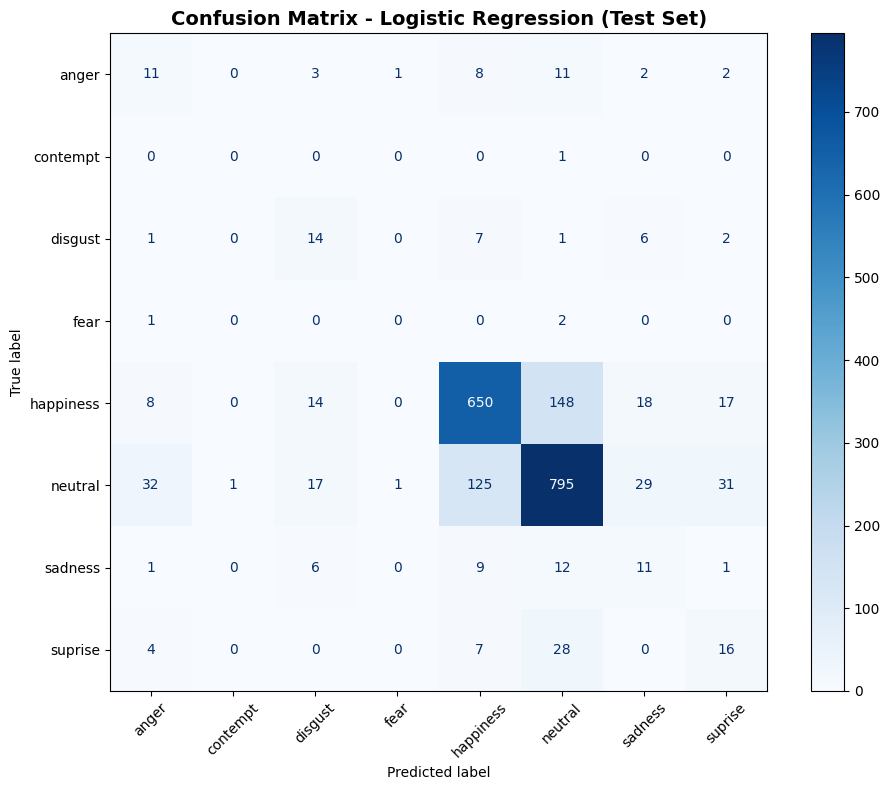


=== Per-Class Performance ===
anger       :   11/  38 correct (28.9%)
contempt    :    0/   1 correct (0.0%)
disgust     :   14/  31 correct (45.2%)
fear        :    0/   3 correct (0.0%)
happiness   :  650/ 855 correct (76.0%)
neutral     :  795/1031 correct (77.1%)
sadness     :   11/  40 correct (27.5%)
suprise     :   16/  55 correct (29.1%)


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get unique emotion labels (sorted for consistent ordering)
emotion_labels = sorted(np.unique(y))

# Compute confusion matrix on test set
cm = confusion_matrix(y_te, y_te_pred, labels=emotion_labels)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=45)
ax.set_title('Confusion Matrix - Logistic Regression (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\n=== Per-Class Performance ===")
for i, emotion in enumerate(emotion_labels):
    true_count = cm[i, :].sum()
    correct = cm[i, i]
    accuracy = correct / true_count if true_count > 0 else 0
    print(f"{emotion:12s}: {correct:4d}/{true_count:4d} correct ({accuracy*100:.1f}%)")

In [10]:
# Save the trained Logistic Regression model to disk
# Uses joblib for efficient persistence of scikit-learn models
import os
import joblib

models_dir = os.path.join('.', 'models')
os.makedirs(models_dir, exist_ok=True)

model_file = os.path.join(models_dir, 'best_logreg.joblib')

# Save the model (LogisticRegression stored in variable 'logreg')
# If `logreg` isn't defined, this will raise an error when run; ensure 'logreg' is a trained model
joblib.dump(logreg, model_file)
print(f"Saved best LogisticRegression model to: {model_file}")


Saved best LogisticRegression model to: ./models/best_logreg.joblib


In [ ]:
# Demo: How to load the saved model from disk
# This shows how to reload a saved scikit-learn model using joblib.
# Note: This code assumes the file exists at the same path used when saving.
model_file = './models/best_logreg.joblib'

# If you wish to avoid actually loading when people run the cell, guard with a flag
LOAD_MODEL_DEMO = True

if LOAD_MODEL_DEMO:
    try:
        loaded_model = joblib.load(model_file)
        print(f"Loaded model from {model_file}; model type: {type(loaded_model)}")
    except FileNotFoundError:
        print(f"Model file not found at {model_file}. Run the save cell above to create it.")
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")
else:
    print("Demo load skipped. Set LOAD_MODEL_DEMO = True to attempt loading the model.")


Loaded model from ./models/best_logreg.joblib; model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
